## Compute Relative SSTs using ERSSTv5 data van Oldenborgh et al (2021) method 
from https://iopscience.iop.org/article/10.1088/1748-9326/abe9ed

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import requests, csv

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


## Load in SST data of interest (full field) and save as xarray

In [2]:
# Monthly ERSSTv5 data (binary format) 
latl = 89
lonl = 180
tim = 2023

fid = 'ersst.v5.1854.pres.gr'
vort = np.fromfile(fid, np.float32).reshape(tim,latl,lonl)
vort[vort < -90] = np.nan
#print(vort.shape)
long = np.arange(0, 360, 2)
lat = np.arange(-88.5,88.5,2)
#print(lat)

# Convert to xarray
times = pd.date_range(start='1854-01-01',freq='1M',periods=tim)

X_grid, Y_grid = np.meshgrid(long,lat)  
ds = xr.DataArray(data=vort,
                  coords={"time": times,
                          "lat": (["y","x"], Y_grid),
                          "lon": (["y","x"], X_grid),
                          },dims=["time","y","x"])

#ds

## Compute tropical mean average and Nino3.4 average 

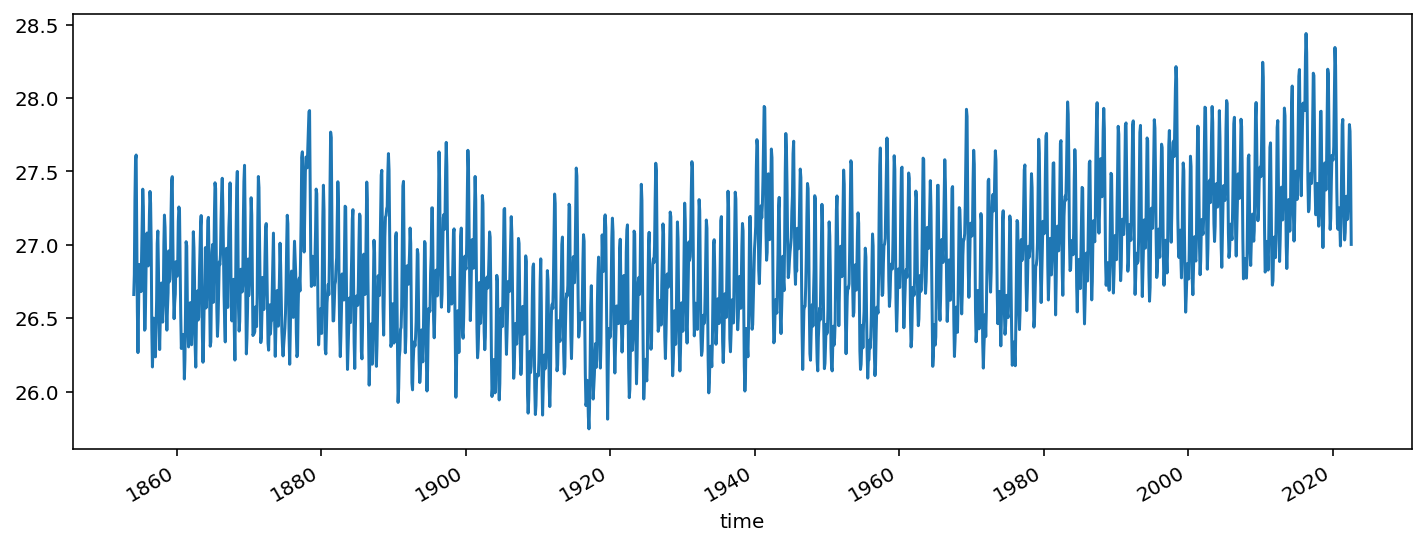

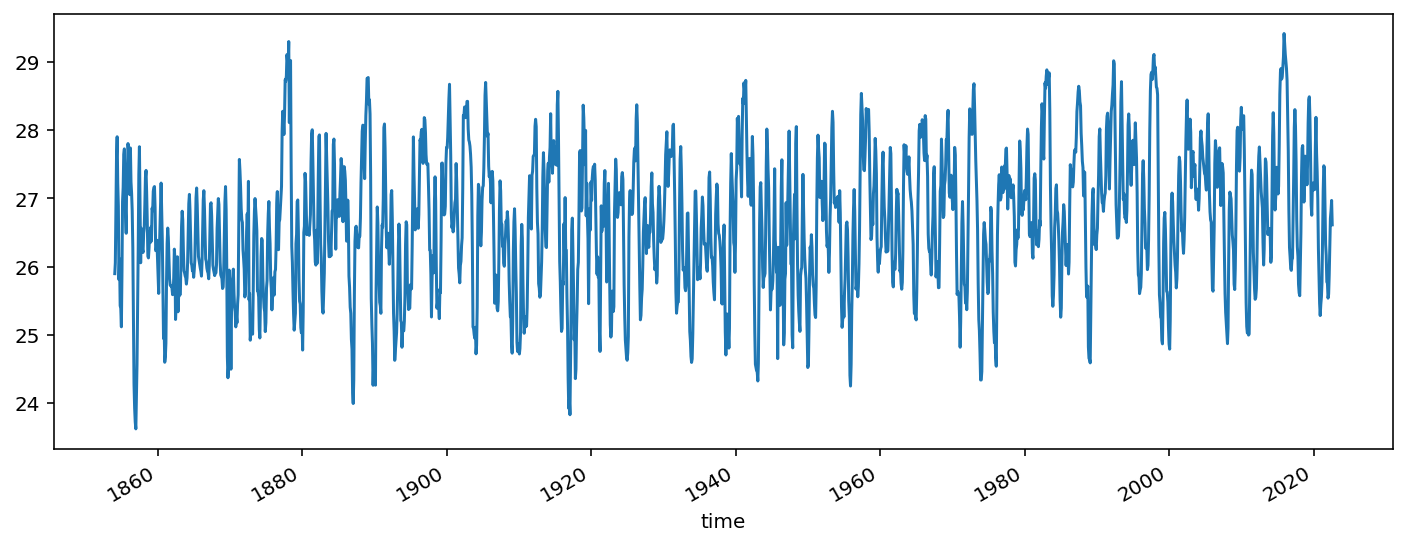

In [3]:
# Tropical Mean lats 
min_lat = -20
max_lat = 20
min_lon = 0 
max_lon = 360

mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
cropped_ds = ds.where(mask_lat & mask_lon, drop=True)
tropmean = cropped_ds.mean(dim=('y','x'))

tropmean.plot(figsize=(12, 4));

# Nino3.4 lats 
min_lat = -5
max_lat = 5
min_lon = 190
max_lon = 240

mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
cropped_ds = ds.where(mask_lat & mask_lon, drop=True)
nino34mean = cropped_ds.mean(dim=('y','x'))

nino34mean.plot(figsize=(12, 4));

# Set climatology and compute anomalies of Nino3.4 and Tropical Mean 



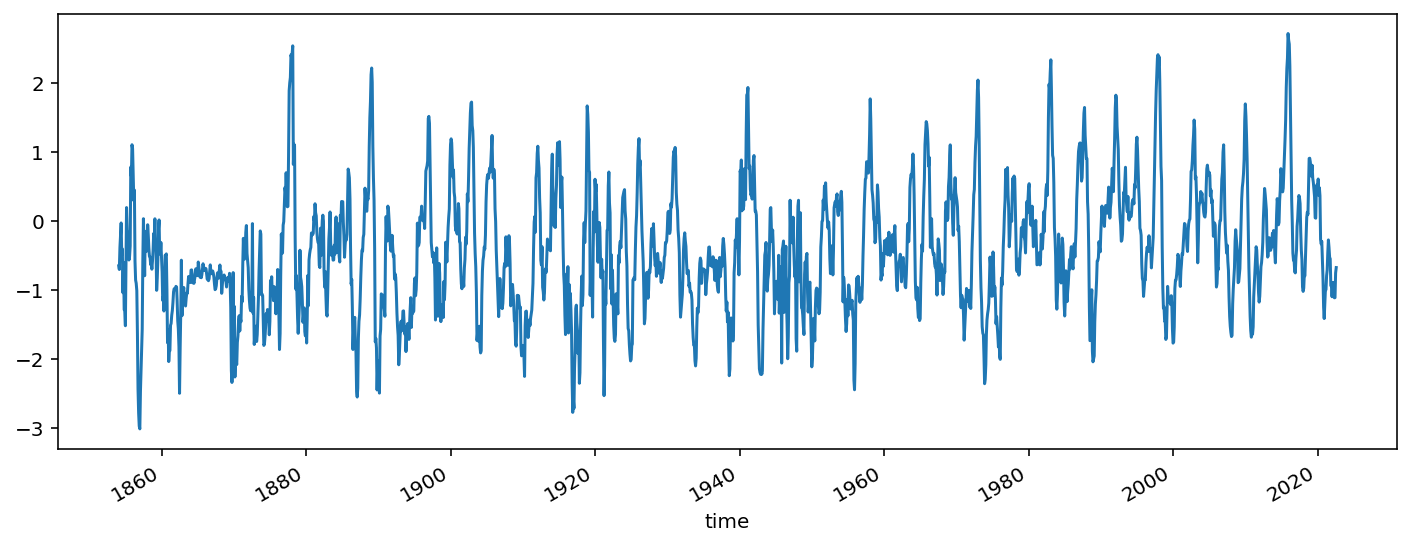

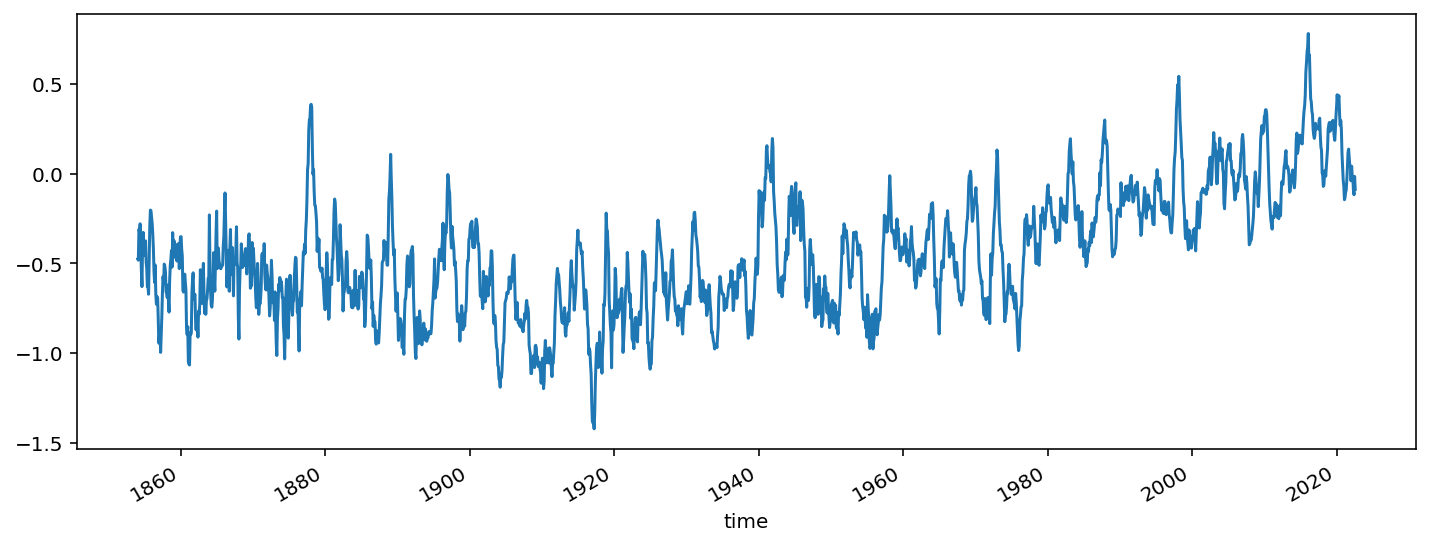

In [4]:
# Set climatology and compute anomalies of Nino3.4 and Tropical Mean 
climrang1 = '1991-01-01'
climrang2 = '2020-12-01'

# Nino3.4 average
clm = nino34mean.sel(time=slice(climrang1,climrang2)).groupby('time.month').mean(dim='time')
nino34a = (nino34mean.groupby('time.month') - clm)
nino34a.plot(figsize=(12, 4));

# Tropical Average
clm = tropmean.sel(time=slice(climrang1,climrang2)).groupby('time.month').mean(dim='time')
tropa = (tropmean.groupby('time.month') - clm)
tropa.plot(figsize=(12, 4));


## Now remove tropical mean anomalies from Nino3.4 index

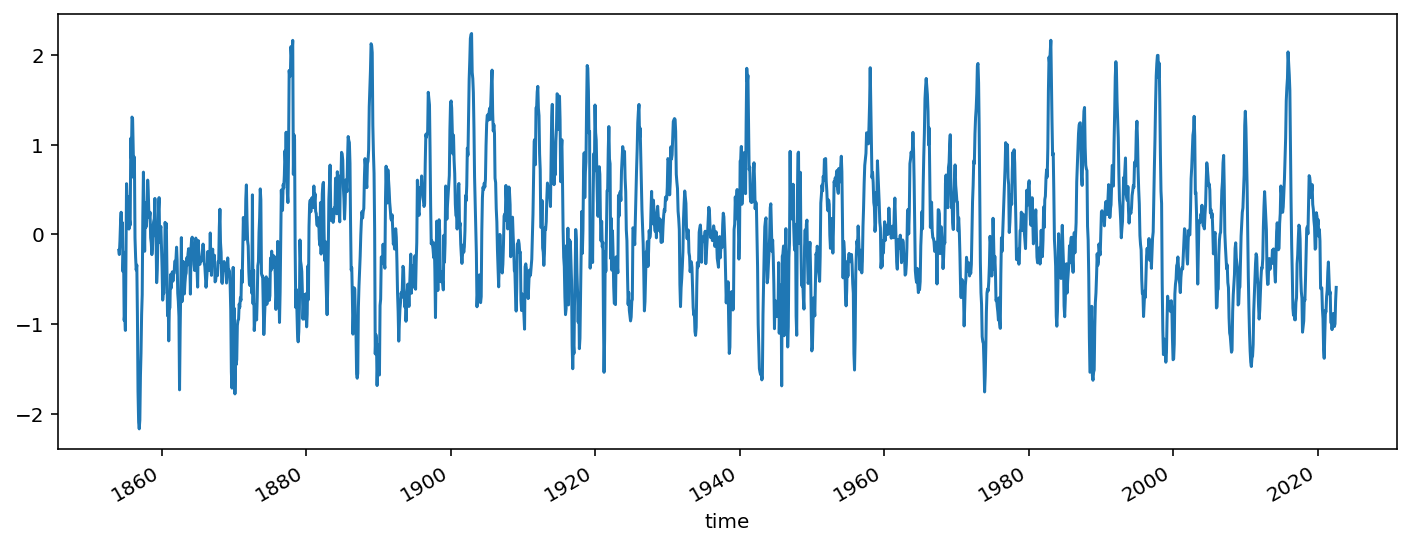

In [5]:
# Now subtract out the tropical average anomaly from Nino-3.4 anomaly
nino34_tropremov = nino34a - tropa
nino34_tropremov.plot(figsize=(12, 4));


# Adjust variance so variance equals Nino3.4 index 

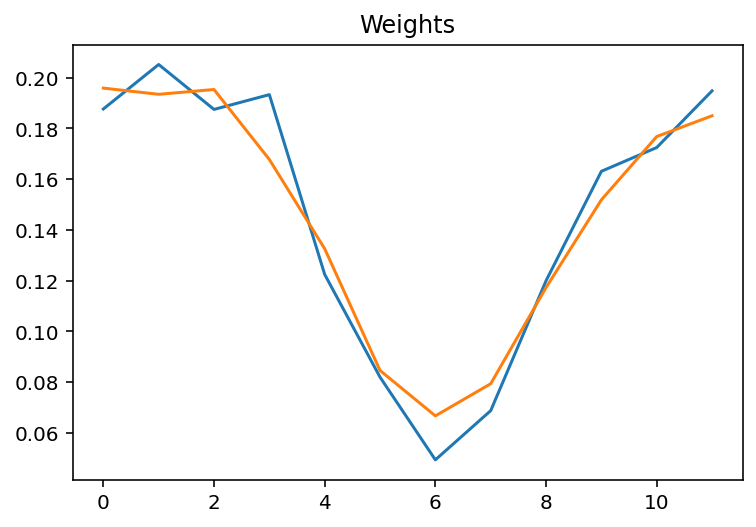

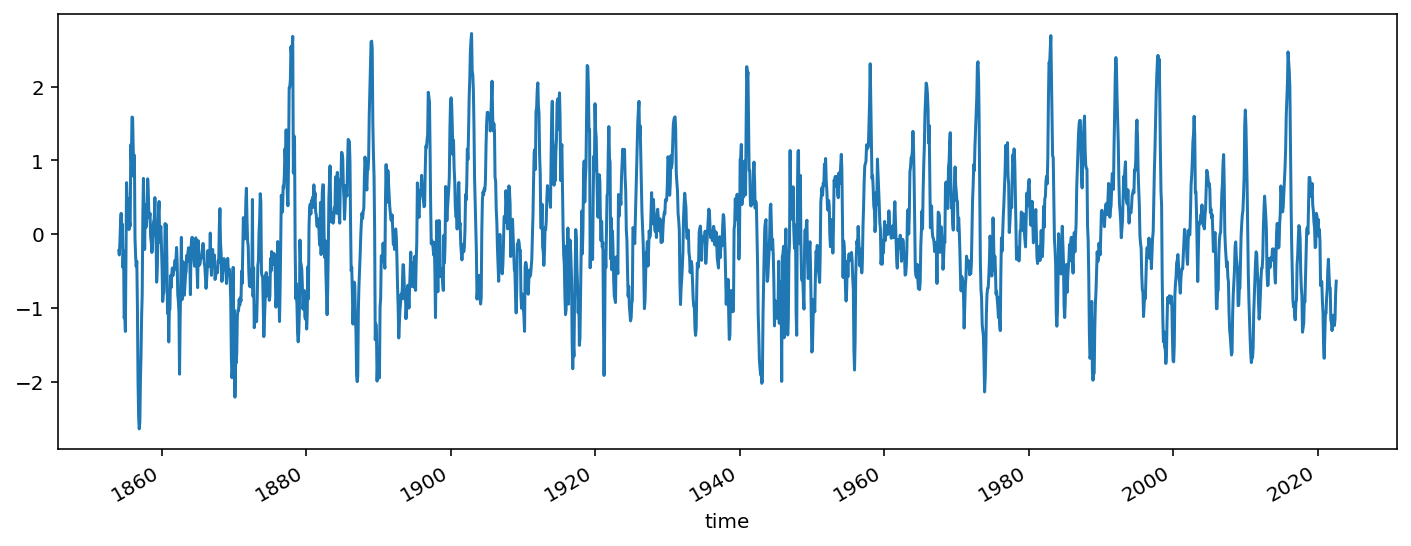

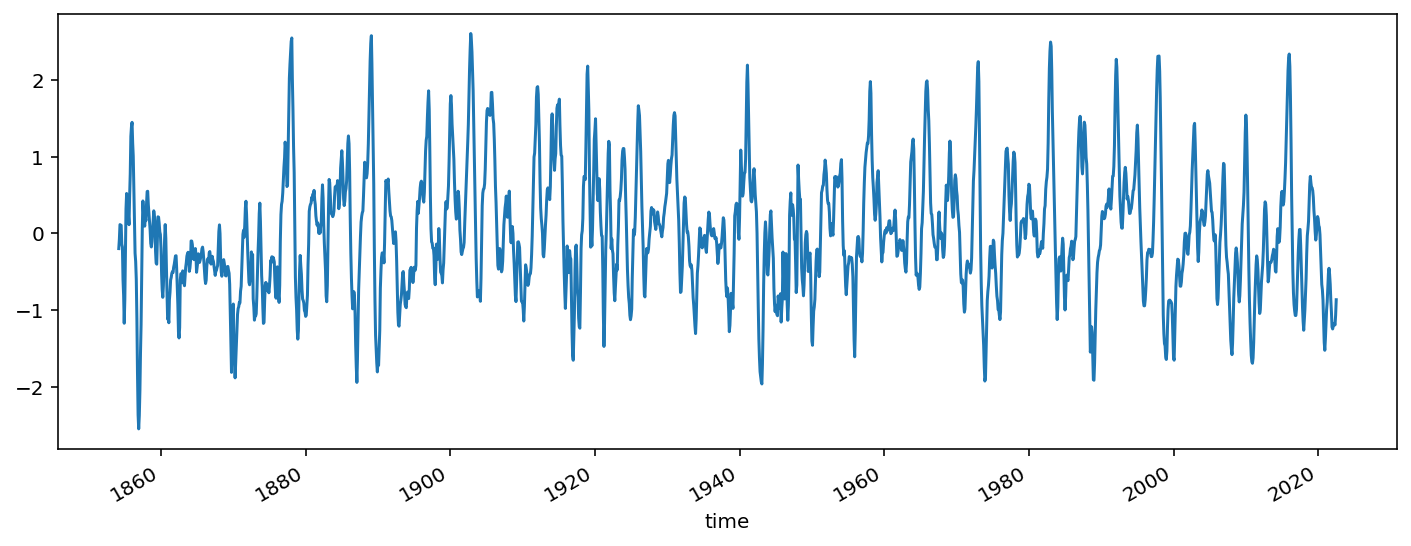

In [6]:
# Reinflate the variance of the time series using regression (compute by calendar month)

## Compute weights on data for 1950 onwards
wght =[]
for mm in np.arange(1,13):
    x = nino34_tropremov.loc[(nino34_tropremov.time.dt.month==mm)&(nino34_tropremov.time.dt.year>=1950)]
    msk = np.isfinite(x)
    y = tropa.loc[(tropa.time.dt.month==mm)&(tropa.time.dt.year>=1950)]
    coef = np.polyfit(x[msk], y[msk], 1)
    val = coef[0]
    wght.append(val)
    #reg_lin = np.poly1d(coef)
    #plt.plot(x[msk],y[msk], 'o', x[msk], reg_lin(x[msk]), '--k')

plt.plot(wght)
# Smooth adjacent monthly weights
exwght = [wght[-1]] + wght + [wght[0]]
smooth_wght = np.convolve(exwght, np.ones(3), 'valid') / 3
plt.plot(smooth_wght)
plt.title('Weights')

# Repeat weights for calendar months and create weights xarray 
# (probably a better way to code this)
noyrs = len(tropa.groupby('time.year').count())
matw = np.tile(smooth_wght,[1,noyrs])  #smoothed weights
#matw = np.tile(wght,[1,noyrs]) #unsmoothed weights
timz = pd.to_datetime(times)
zz = matw[0,0:len(nino34_tropremov)].squeeze()
df_wght = xr.DataArray(zz, dims=['time'], coords={'time': timz})
#df_wght.plot(figsize=(12, 4));

# Compute adjusted relative index
relative_nino34a = nino34_tropremov /(1 - df_wght)
relative_nino34a.plot(figsize=(12, 4));

###### Seasonal avg the mthly total data  ######
# Note that first and last points are now NaN
seasavg = relative_nino34a.rolling(time=3, center=True).mean()
seasavg.plot(figsize=(12, 4));

# Round to two decimals 
seasavgalt = np.round(seasavg,2)


## Load in RONI from CPC web

In [7]:
RONI_url = 'https://www.cpc.ncep.noaa.gov/data/indices/RONI.ascii.txt'
df = pd.read_csv(RONI_url, delimiter=r"\s+")
df = df.rename({'YR': 'Year', 'SEAS': 'Season','ANOM':'cpc_roni'}, axis=1) 
df.index = pd.date_range(start='1950-01-01',freq='1M',periods=len(df))
ds = df.to_xarray()
ds = ds.rename({'index': 'time'})
ds

<xarray.Dataset>
Dimensions:   (time: 870)
Coordinates:
  * time      (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2022-06-30
Data variables:
    Season    (time) object 'DJF' 'JFM' 'FMA' 'MAM' ... 'FMA' 'MAM' 'AMJ' 'MJJ'
    Year      (time) int64 1950 1950 1950 1950 1950 ... 2022 2022 2022 2022 2022
    cpc_roni  (time) float64 -1.45 -1.22 -1.01 -0.96 ... -1.17 -1.19 -1.06 -0.86

## Compare web version with this python code

No handles with labels found to put in legend.


<xarray.Dataset>
Dimensions:   (time: 2023)
Coordinates:
  * time      (time) datetime64[ns] 1854-01-31 1854-02-28 ... 2022-07-31
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 9 10 11 12 1 2 3 4 5 6 7
Data variables:
    RONI      (time) float64 nan -0.1993 -0.07405 0.1137 ... -1.067 -0.8664 nan
    Season    (time) object nan nan nan nan nan ... 'FMA' 'MAM' 'AMJ' 'MJJ' nan
    Year      (time) float64 nan nan nan nan ... 2.022e+03 2.022e+03 nan
    cpc_roni  (time) float64 nan nan nan nan nan ... -1.17 -1.19 -1.06 -0.86 nan


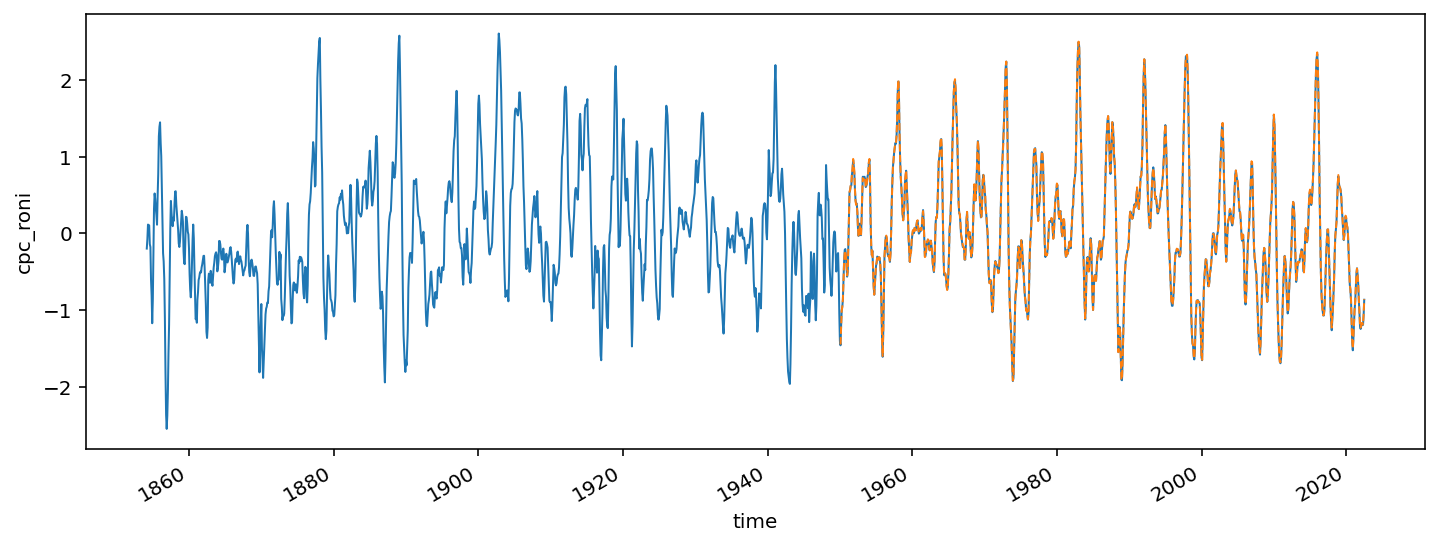

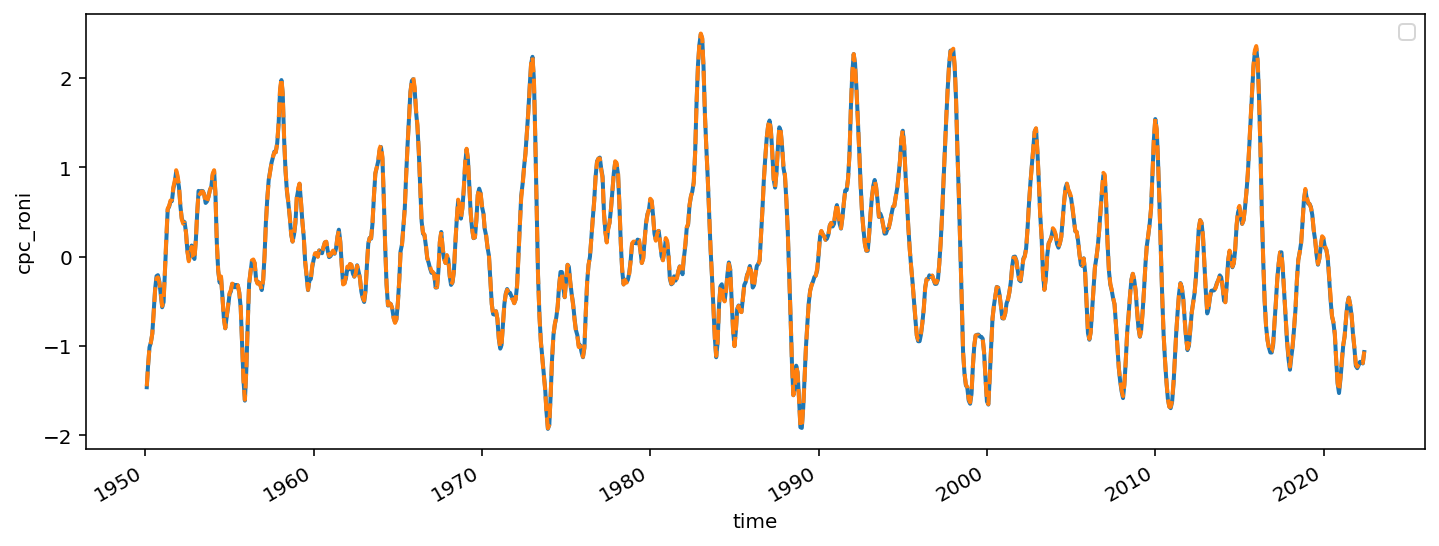

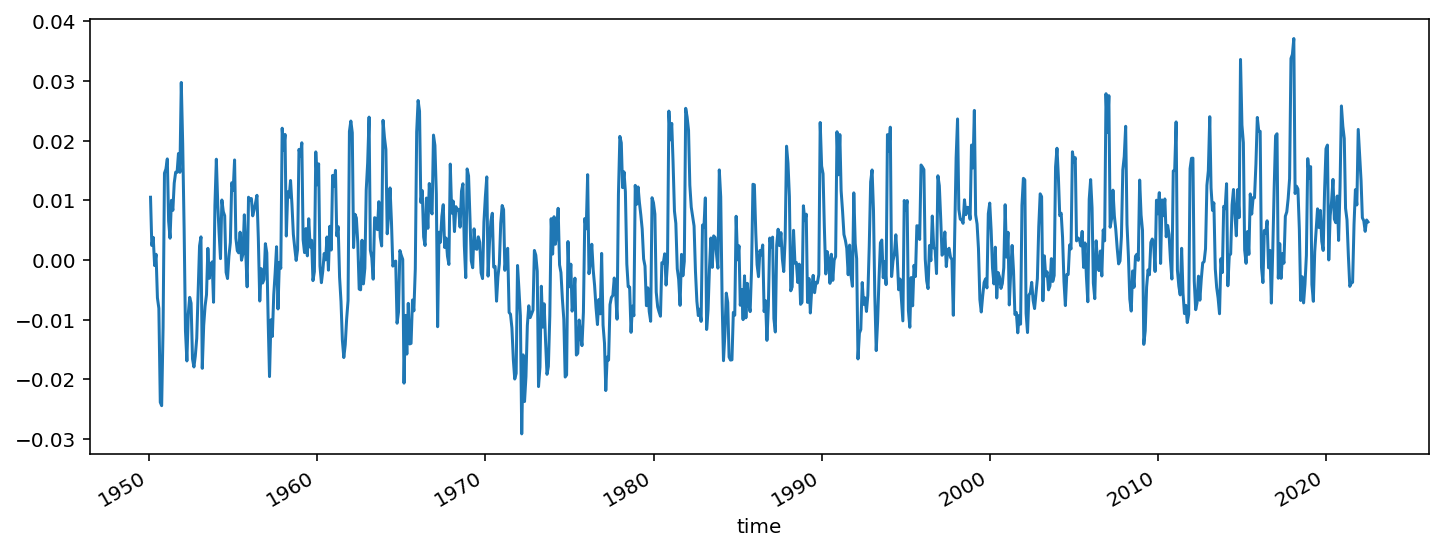

In [8]:
df_RONI = xr.DataArray.to_dataset(seasavg,name='RONI')

da_merged = xr.merge([df_RONI, ds])
print(da_merged)


fig, ax = plt.subplots(figsize=(12, 4))
da_merged.RONI.plot(ax=ax,x='time',linewidth=1)
da_merged.cpc_roni.plot(ax=ax,x='time',linewidth=1,linestyle='dashed')

fig, ax = plt.subplots(figsize=(12, 4))
da_merged.RONI.sel(time=slice('1950-01-01','2022-06-01')).plot(ax=ax,x='time',linewidth=2)
da_merged.cpc_roni.sel(time=slice('1950-01-01','2022-06-01')).plot(ax=ax,x='time',linewidth=2,linestyle='dashed')
legend = ax.legend();


#diff = ds.cpc_roni - seasavgalt
diff = ds.cpc_roni - seasavg
diff.plot(figsize=(12, 4));